
# Data cleaning and prepareation

Analyze data from comments to find most frequnetly used words, prepare the data for modeling 

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()



from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/xinhongli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/xinhongli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xinhongli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Getting comments from saved data files


In [136]:
df_comments_college = pd.read_csv('./Data/comments_college.csv')

In [137]:
df_comments_college.shape

(1475, 4)

In [138]:
df_comments_college.head(3)

,Unnamed: 0,subreddit,body,created_utc
0,0,ApplyingToCollege,There’s 200 seats in that class rn and literal...,1648412159
1,1,ApplyingToCollege,"I meant whatever your intended major is, try t...",1648412154
2,2,ApplyingToCollege,Dude did you even apply to any safeties/target...,1648412150


In [139]:
df_comments_gardenging = pd.read_csv('./Data/comments_gardening.csv')

In [140]:
df_comments_gardenging.shape

(1500, 4)

## combine comments from two subreddits to one DataFrame

In [141]:
df_comments = pd.concat([df_comments_college[['body', 'subreddit']], df_comments_gardenging[['body', 'subreddit']]], ignore_index=True)

In [142]:
df_comments.head()

,body,subreddit
0,There’s 200 seats in that class rn and literal...,ApplyingToCollege
1,"I meant whatever your intended major is, try t...",ApplyingToCollege
2,Dude did you even apply to any safeties/target...,ApplyingToCollege
3,that is SO awful :(( what in the world?? I ju...,ApplyingToCollege
4,I have to wait till 9 pm for when my mom gets ...,ApplyingToCollege


In [143]:
df_comments.shape

(2975, 2)

In [144]:
df_comments.tail()

,body,subreddit
2970,"If you’re lucky, you’ll be an older person one...",gardening
2971,This reminds me of a girl I knew that would sh...,gardening
2972,"Reminds me of the old joke, ""do you smoke afte...",gardening
2973,"Great idea, creative problem solving. Keep up ...",gardening
2974,"Not sure if it's universal, but everywhere her...",gardening


## Set a column for target, is_college 

The value is 1 if the comment is from ApplyTo_college , the value is 0 if the comment  is from garning sunreddit

In [145]:

df_comments['is_college'] = df_comments['subreddit'].map({'ApplyingToCollege': 1, 'gardening': 0})
df_comments.drop('subreddit', axis=1, inplace=True)
df_comments.head()

,body,is_college
0,There’s 200 seats in that class rn and literal...,1
1,"I meant whatever your intended major is, try t...",1
2,Dude did you even apply to any safeties/target...,1
3,that is SO awful :(( what in the world?? I ju...,1
4,I have to wait till 9 pm for when my mom gets ...,1


In [146]:
df_comments.tail()

,body,is_college
2970,"If you’re lucky, you’ll be an older person one...",0
2971,This reminds me of a girl I knew that would sh...,0
2972,"Reminds me of the old joke, ""do you smoke afte...",0
2973,"Great idea, creative problem solving. Keep up ...",0
2974,"Not sure if it's universal, but everywhere her...",0


## Drop duplicates

In [147]:
df_comments.duplicated().sum()

66

In [148]:
df_comments[df_comments.duplicated()]

,body,is_college
31,"I meant whatever your intended major is, try t...",1
32,[removed],1
73,[removed],1
125,[removed],1
177,[removed],1
...,...,...
2917,thank you!,0
2941,Thanks!,0
2948,Thank you!,0
2953,Plant cummies,0


In [149]:
df_comments.drop_duplicates(inplace = True)

In [150]:
df_comments.shape

(2909, 2)

In [151]:
df_comments = df_comments.reset_index(drop=True)
df_comments.tail()

,body,is_college
2904,"If you’re lucky, you’ll be an older person one...",0
2905,This reminds me of a girl I knew that would sh...,0
2906,"Reminds me of the old joke, ""do you smoke afte...",0
2907,"Great idea, creative problem solving. Keep up ...",0
2908,"Not sure if it's universal, but everywhere her...",0


## Wordclouds 

In [154]:
# inspired by  stackhouse 
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=42).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

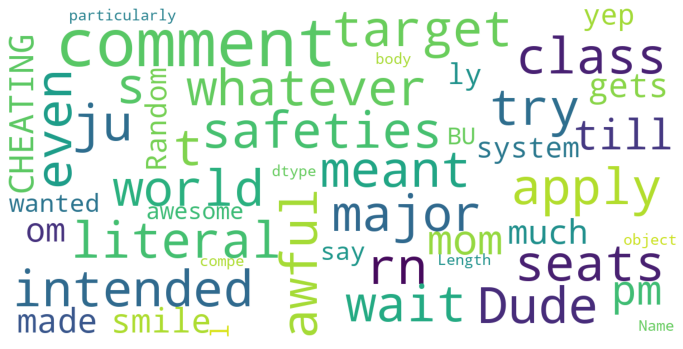

In [155]:
show_wordcloud(df_comments_college['body'])

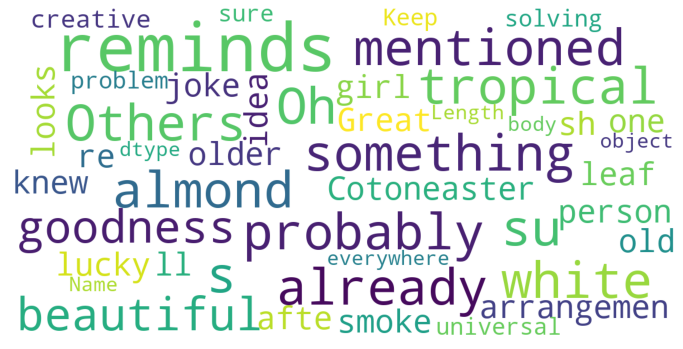

In [156]:
show_wordcloud(df_comments_gardenging['body'])

## Split data into train set and test set

In [157]:
# Train/Test split
X = df_comments['body']
y = df_comments['is_college']
X_train, X_test, y_train, y_test = train_test_split(df_comments, y, random_state=42, stratify=y)

## Use CountVectorizer to convert data 

Find out frequently used words from 2 subreddits 

In [162]:
cv = CountVectorizer(stop_words='english')
X_train_cv = cv.fit_transform(X_train['body'])

cv_train = pd.DataFrame(X_train_cv.todense(), columns=cv.get_feature_names())

In [163]:
n_words = 30
words = list(cv_train.sum().sort_values(ascending=False)[:n_words].index)
cv_train['is_college'] = y_train.values
cv_train_small = cv_train.groupby('is_college').sum()[words]
cv_train_small.head()

,like,just,got,don,school,good,year,plant,think,soil,...,sure,did,going,thank,time,lot,use,great,make,water
is_college,,,,,,,,,,,,,,,,,,,,,
0,180,156,26,91,5,79,97,148,51,131,...,46,43,37,64,60,47,64,40,43,75
1,121,127,177,109,172,89,54,1,95,0,...,48,50,53,26,26,39,18,39,32,0


plot 

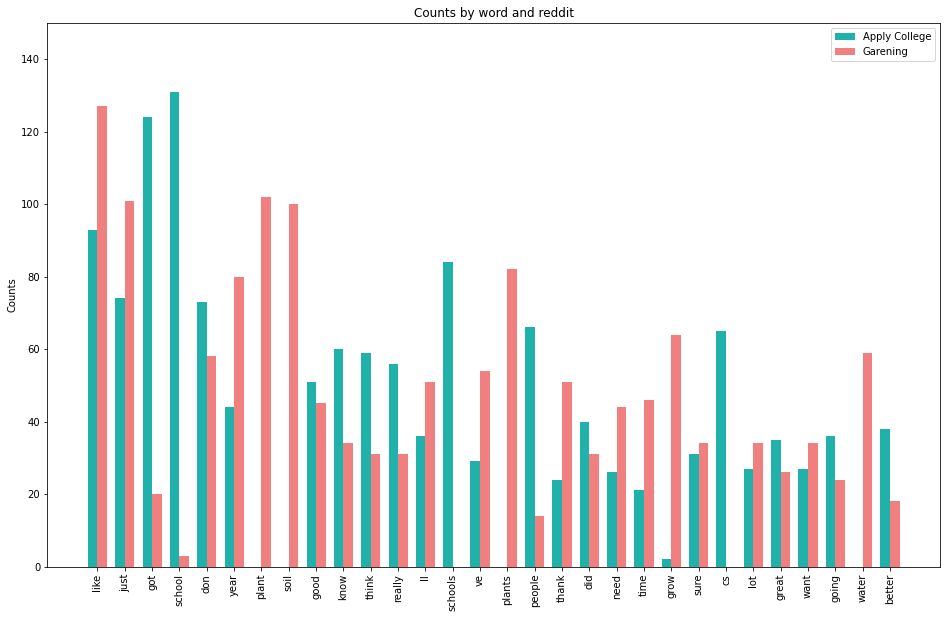

In [125]:
words_college = words
words_count_college = cv_train_small.loc[1]
words_gardening = words
words_count_gardening = cv_train_small.loc[0]
width = 0.35       # the width of the bars
ind = np.arange(n_words)

fig, ax = plt.subplots(figsize=(16, 10))
rects1 = ax.bar(ind, words_count_college, width, color='lightseagreen')
rects2 = ax.bar(ind+width,words_count_gardening, width, color='lightcoral')

# add some text for labels, title and axes ticks
ax.set_ylabel('Counts')
ax.set_title('Counts by word and reddit')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(words,rotation='vertical')

ax.set_ylim(0,150)

ax.legend((rects1[0], rects2[0]), ('Apply College', 'Garening'))

plt.show()

## lemmatize words

In [164]:
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    words = text.split()
    lemma_words = ''
    for word in words:
        lemma_words += (lemmatizer.lemmatize(word) + ' ')
    return lemma_words    


In [165]:
df_comments['body'] = df_comments['body'].apply(lemmatize_words)

In [166]:
df_comments.shape

(2909, 2)

In [167]:
# drop rows where body = ''
df_comments = df_comments[df_comments['body'] != '']
df_comments = df_comments.reset_index(drop=True)

## Most frequenly used word for college application

In [168]:
# get most frequently used words: change max_features

count_vector = CountVectorizer(analyzer = "word", 
                              tokenizer = None, 
                              preprocessor = None,
                              stop_words = "english", 
                              max_features = 35) 

# input for CountVectorizer is an array of strings
vector_input_college = df_comments[df_comments['is_college'] == 1]['body']

# fit_transform the vectorizer
college_words = count_vector.fit_transform(vector_input_college)

# convert output to a Numpy array
college_words = college_words.toarray()

In [169]:
# get the words
college_word_list = count_vector.get_feature_names()
print(college_word_list)

['acceptance', 'applied', 'better', 'class', 'college', 'cs', 'did', 'didn', 'don', 'essay', 'going', 'good', 'got', 'ha', 'just', 'know', 'like', 'll', 'lot', 'major', 'people', 'pretty', 'program', 'really', 'safety', 'school', 'state', 'student', 'sure', 'thing', 'think', 've', 'wa', 'want', 'year']


By looking at the list, it would be better to remove some words, such as did, didn ha ll etc

## Most frequenly used word for gardening

In [171]:


count_vector = CountVectorizer(stop_words = "english", 
                               max_features = 35) 

vector_input_gardening = df_comments[df_comments['is_college'] == 0]['body']

# fit_transform the vectorizer
gardenging_words = count_vector.fit_transform(vector_input_gardening)

# convert output to a Numpy array
gardenging_words = gardenging_words.toarray()

In [172]:
gardenging_word_list = count_vector.get_feature_names()
print(gardenging_word_list)

['bed', 'don', 'flower', 'garden', 'good', 'grow', 'growing', 'just', 'know', 'leaf', 'like', 'll', 'look', 'lot', 'love', 'make', 'need', 'plant', 'pot', 'seed', 'soil', 'start', 'sure', 'thank', 'thing', 'think', 'time', 'tree', 'try', 'use', 've', 'wa', 'want', 'water', 'year']


### Add some stop words from the most frequently used words

In [175]:
from sklearn.feature_extraction import text

text.ENGLISH_STOP_WORDS
,
add_stop_words = ['did', 'didn','just' 'doe','ll', 'don', 'doesn', 'getting','ve' 'going', 'got', 'ha', 'isn', 'wa']

stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

stop_words

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

### save comments for modeling 

In [178]:
df_comments.to_csv('./Data/comments.csv')